In [1]:
from tensorflow.python.keras import models
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.keras import optimizers
from tensorflow.python.keras import activations
from tensorflow.python.keras import callbacks
from tensorflow.python.keras import initializers
from tensorflow.python.keras import backend
from tensorflow.python.keras import metrics
from tensorflow import keras
import tensorflow as tf
import keras_tuner as kt
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
train_x_rc = np.load('../data/train_x_rc.npy')
train_x_other = np.load('../data/train_x_other.npy')
targets = np.load('../data/target.npy')
print(train_x_other.shape)
print(train_x_rc.shape)
print(targets.shape)

(75450, 80, 10)
(75450, 80, 15)
(75450, 80)


In [3]:
rc_num = 15
ox = 10
train_x = np.concatenate([train_x_rc, train_x_other], axis=-1)
x_train, x_test, y_train, y_test = train_test_split(train_x, targets, test_size=0.15, random_state=43)
x_train_rc = x_train[:, :, :rc_num][:, 0]
x_train_ox = x_train[:, :, -ox:]
x_test_rc = x_test[:, :, :rc_num][:, 0]
x_test_ox = x_test[:, :, -ox:]

In [4]:
class ExpandTileLayer(layers.Layer):
    def __init__(self):
        super(ExpandTileLayer, self).__init__()
    def call(self, inputs, *args, **kwargs):
        return backend.tile(backend.expand_dims(inputs, axis=-2), (1, 80, 1))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
rc_input_layer (InputLayer)     [(None, 15)]         0                                            
__________________________________________________________________________________________________
rc_embed_layer (Dense)          (None, 32)           480         rc_input_layer[0][0]             
__________________________________________________________________________________________________
other_x_input (InputLayer)      [(None, 80, 10)]     0                                            
__________________________________________________________________________________________________
expand_tile_layer (ExpandTileLa (None, 80, 32)       0           rc_embed_layer[0][0]             
______________________________________________________________________________________________

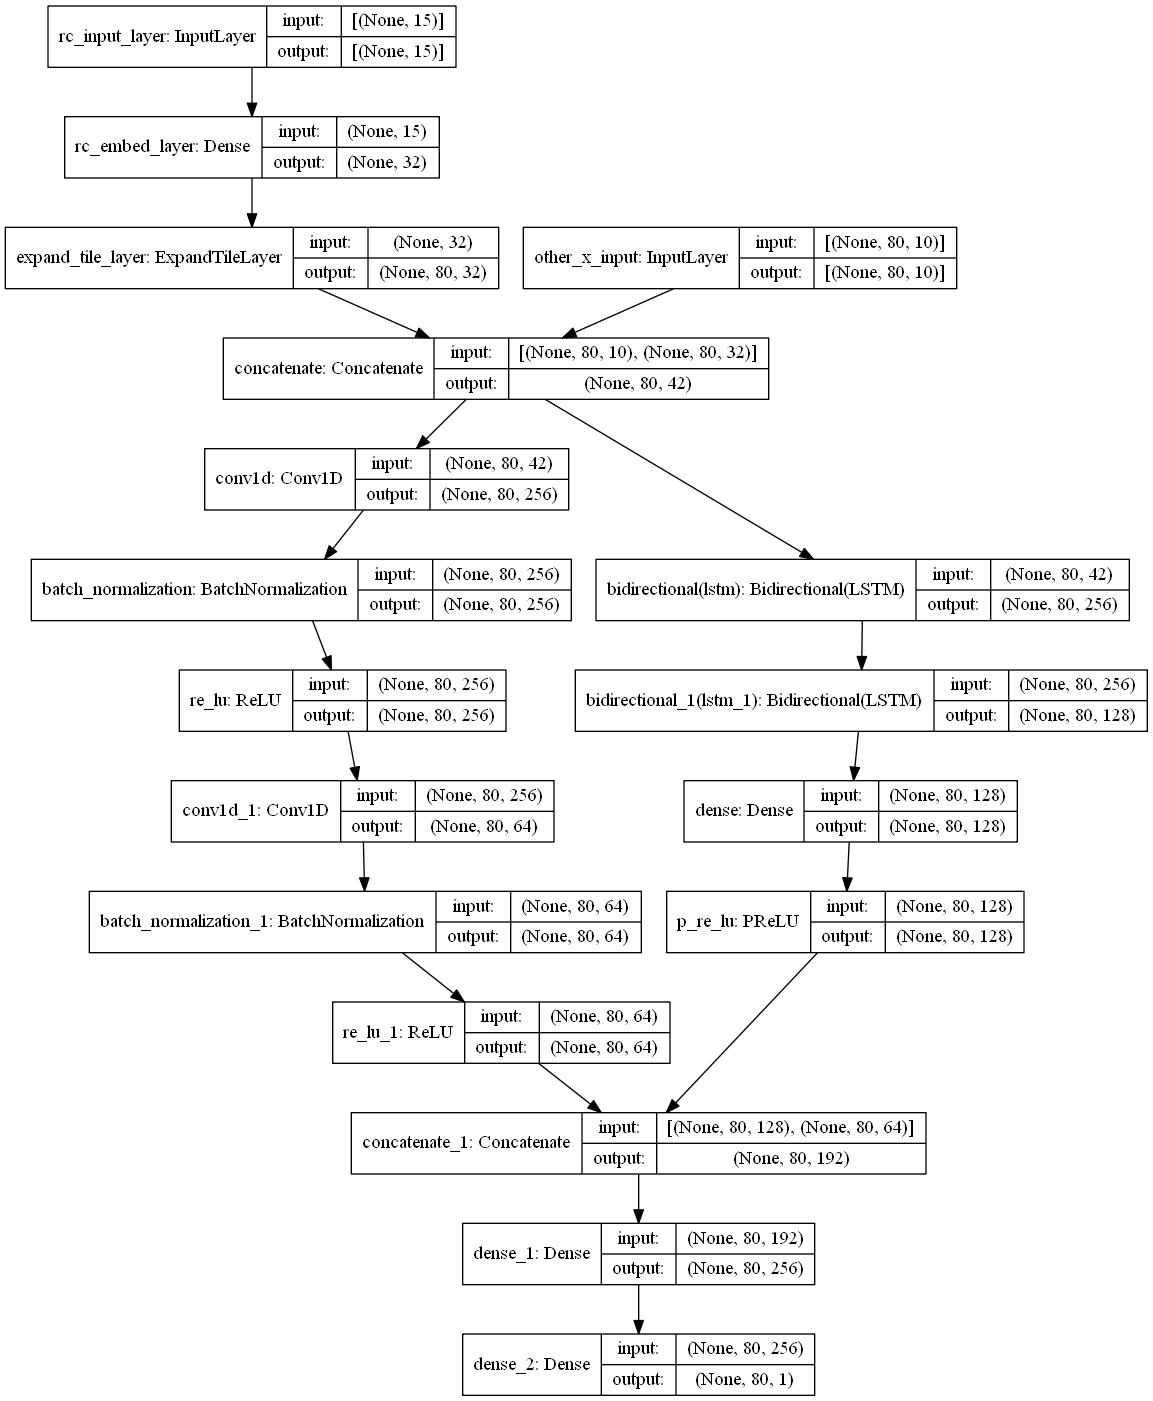

In [5]:
rc_input = keras.Input(shape=(train_x_rc.shape[-1], ),
                       dtype='int32',
                       name='rc_input_layer')
other_x_input = keras.Input(shape=(80, train_x_other.shape[-1]),
                            dtype='float32',
                            name='other_x_input')
rc_embedding_layer = layers.Dense(units=32,
                                  use_bias=False, name='rc_embed_layer')
rc_embedding = rc_embedding_layer(rc_input)

# 维度拓展
rc_embedding = ExpandTileLayer()(rc_embedding)

x_input = layers.Concatenate(axis=-1)([other_x_input, rc_embedding])
ox = layers.Bidirectional(layers.LSTM(units=128,
                                      return_sequences=True,
                                      kernel_initializer=initializers.initializers_v2.GlorotUniform()),
                          merge_mode='concat')(x_input)

ox = layers.Bidirectional(layers.LSTM(units=64,
                                      return_sequences=True,
                                      kernel_initializer=initializers.initializers_v2.GlorotUniform()),
                          merge_mode='concat')(ox)
ox = layers.Dense(units=128,
                  kernel_initializer=initializers.initializers_v2.GlorotUniform())(ox)
# if hp.Choice('d2_activation', ['prelu', 'elu']) == 'prelu':
lstm_output = layers.PReLU()(ox)
# else:
#     lstm_output = layers.ELU()(ox)

conv1d_1 = layers.Conv1D(filters=256,
                         kernel_size=11,
                         padding='same', use_bias=False)(x_input)
conv1d_1 = layers.BatchNormalization()(conv1d_1)
conv1d_1 = layers.ReLU()(conv1d_1)
conv1d_2 = layers.Conv1D(filters=64, padding='same', use_bias=False,
                         kernel_size=5)(conv1d_1)
conv1d_2 = layers.BatchNormalization()(conv1d_2)
conv1d_output = layers.ReLU()(conv1d_2)

output = layers.Concatenate(axis=-1)([lstm_output, conv1d_output])
output = layers.Dense(units=256,
                      activation=activations.relu,
                      kernel_initializer=initializers.initializers_v2.GlorotUniform())(output)
output = layers.Dense(units=1,
                      kernel_initializer=initializers.initializers_v2.GlorotUniform())(output)

my_model = models.Model(inputs=[rc_input, other_x_input], outputs=[output])

my_callbacks = [callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1),
                callbacks.EarlyStopping(monitor='val_loss', patience=31, verbose=1, mode='min', restore_best_weights=True),
                callbacks.ModelCheckpoint('./checkpoint', monitor='val_loss', verbose=1, save_best_only=True,
                                          save_weights_only=False, save_freq='epoch')]
my_model.compile(loss=losses.MeanAbsoluteError(),
                 optimizer=optimizers.Adam(),
                 metrics=[metrics.MeanAbsoluteError()])
print(my_model.summary())
keras.utils.plot_model(my_model, 'my_model_1.png',
                       show_shapes=True,
                       show_layer_names=True)

In [7]:
my_model.fit(x=[x_train_rc, x_train_ox], y=y_train,
             epochs=128,
             batch_size=128,
             validation_data=([x_test_rc, x_test_ox], y_test),
             callbacks=my_callbacks,
             verbose=1)
my_model.save('./my_model_1_o_train')

Epoch 1/128
  9/502 [..............................] - ETA: 26:29 - loss: 2.3792 - mean_absolute_error: 2.3792

KeyboardInterrupt: 

In [ ]:
test_callbacks = [callbacks.ModelCheckpoint('./my_model_1_alld', monitor='loss', save_best_only=True),
                  callbacks.EarlyStopping(monitor='loss', patience=25, restore_best_weights=True, mode='min'),
                  callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=8)]
my_model.fit(x=[x_test_rc, x_test_ox], y=y_test,
             batch_size=128,
             epochs=48,
             verbose=1)
my_model.save('./my_model_1_alld')
